In [1]:
include("./src/Integer.jl")

Main.Integer

In [2]:
using .Integer
using Combinatorics
using LinearAlgebra
using LaTeXStrings
using Plots

pyplot()

Plots.PyPlotBackend()

In [3]:
Na = 60; # numer of atoms
Ls = 3; # number of wells

### The particle conserved basis

In [4]:
Hbs = Vector{Int64}[] 
ps = integer_partition(Na, Ls);
for p in ps
    append!(Hbs, collect(multiset_permutations(p, Ls)))
end

In [5]:
Lb = length(Hbs) # the dimension of the Hilbert space

1891

In [6]:
Lb_shouldbe = binomial(Na+Ls-1, Na)

1891

### The hopping Hamiltonian

In [7]:
H3s1 = hopping_pair(m=1, Na=Na, Hbs=Hbs);
H3s2 = hopping_pair(m=2, Na=Na, Hbs=Hbs);

In [8]:
H3s = H3s1 + H3s2;

In [9]:
Hhop = H3s + H3s';

### The onsite interaction

In [10]:
Honsite = zeros(Float64, Lb, Lb);

In [11]:
for j in 1:Lb
    for k in 1:Lb
        if j == k
            Honsite[j,k] = Hbs[j][1]^2 + Hbs[j][2]^2 + Hbs[j][3]^2
        end
    end
end

In [12]:
Honsite = (1/Na) * Honsite;

### The Nearest-Neighbor interaction

In [13]:
Hnn = zeros(Float64, Lb, Lb);

In [14]:
for j in 1:Lb
    for k in 1:Lb
        if j == k
            Hnn[j,k] = -Hbs[j][1]*Hbs[j][2] - Hbs[j][2]*Hbs[j][3] + Hbs[j][1]*Hbs[j][3]
        end
    end
end

In [15]:
Hnn = (2/Na) * Hnn;

### The tilt potential

In [16]:
Htit = zeros(Float64, Lb, Lb);

In [17]:
for j in 1:Lb
    for k in 1:Lb
        if j == k
            Htit[j,k] = Hbs[j][3] - Hbs[j][1]
        end
        
    end
end

### Eigen-energies

In [18]:
H(U0, U1, ep) = (1/sqrt(2))*Hhop + U0*Honsite + U1*Hnn + ep*Htit

H (generic function with 1 method)

In [19]:
U = 0:0.2:2
eig_mat1 = zeros(Float64, Lb, length(U))
i1 = 1
for j in U
    eig_mat1[:,i1] = eigvals(H(j,j,0)/Na)
    i1 += 1
end

In [20]:
p1 = plot(xlab=L"$U/J$", ylab=L"$E/(JN)$", legend=false);

In [21]:
for i in 1:Lb
    plot!(p1, U, eig_mat1[i,:])
end

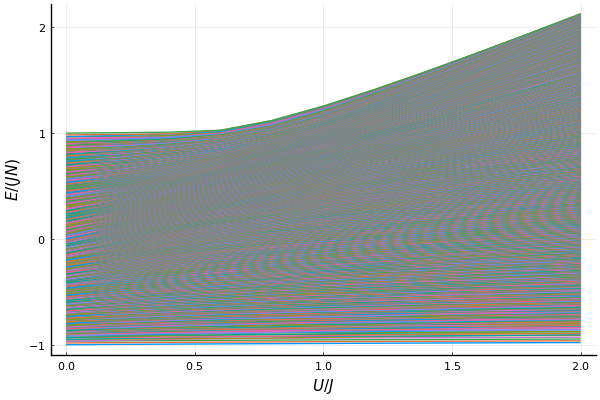

In [22]:
p1

In [23]:
eps = 0:0.1:3
eig_mat2 = zeros(Float64, Lb, length(eps))
i2 = 1
for ep in eps
    eig_mat2[:,i2] = eigvals(H(0.4,0.4,ep)/Na)
    i2 += 1
end

In [24]:
p2 = plot(xlab=L"$\epsilon/J$", ylab=L"$E/(JN)$", legend=false, xlim=(0.1, 0.5),ylim=(0,0.9));
p3 = plot(xlab=L"$\epsilon/J$", ylab=L"$E/(JN)$", legend=false, xlim=(0.8,2.5),ylim=(0,0.9));

In [25]:
for i in 1:Lb
    plot!(p2, eps, eig_mat2[i,:])
    plot!(p3, eps, eig_mat2[i,:])
end

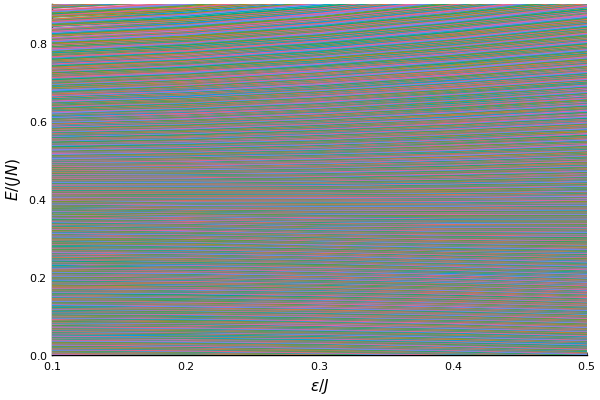

In [26]:
p2

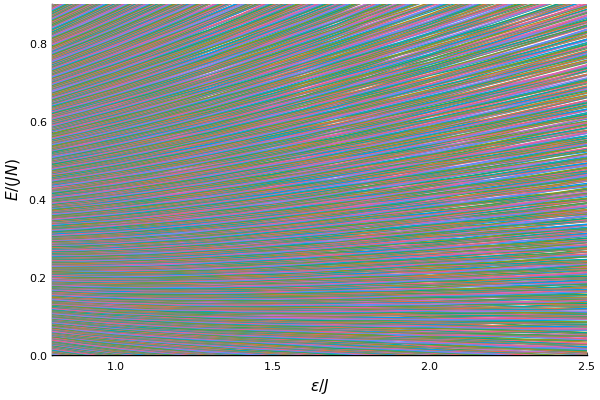

In [27]:
p3

### Level spacing distribution

In [73]:
Htot = H(1.5,1.8,2.3)
vals = eigvals(Htot);
#vals = vals[500:1600]
vecs = eigvecs(Htot);

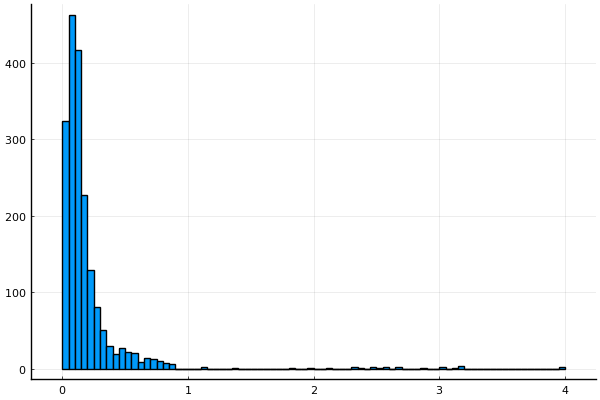

In [74]:
# The distribution of level spacing before unfolding
diffs = [vals[i+1]-vals[i] for i in 1:length(vals)-1];
histogram(diffs, bins=:100, legend=false)

In [75]:
# In our case, we take average every 5 levels, we drop (5-1)/2 spacings at either end.
v = 5
index1 = Int((v-1)/2)
index2 = length(diffs)-index1
diffs_dropped = diffs[index1:index2];

In [76]:
function average_spacing(differences::Vector{Float64}, i::Int64, v::Int64)
    drop_index = Int((v-1)/2)
    @assert i-drop_index > 0
    @assert i+drop_index <= length(differences)
    sum = 0
    for k in -drop_index:drop_index
        sum += differences[i+k]
    end
    return sum/v
end

average_spacing (generic function with 1 method)

In [77]:
v = 5
new_diffs = []
for i in 1:length(diffs_dropped)
    drop_index = Int((v-1)/2)
    if i-drop_index>0 && i+drop_index<=length(diffs_dropped)
        append!(new_diffs, diffs_dropped[i]/average_spacing(diffs_dropped, i, v))
    end
end

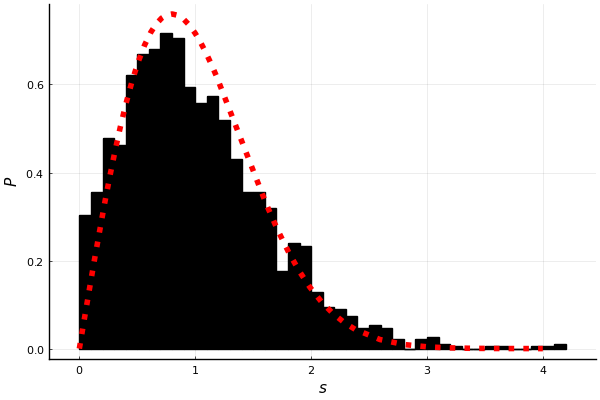

In [78]:
p = plot(xlabel=L"s", ylabel=L"P")
f(x) = (π*x/2)*exp(-π*x^2/4)
histogram!(p, new_diffs, bins=50, normed=true, legend=false, color=:black)
plot!(p, f, 0, 4, linestyle=:dot, linewidth=4, color=:red)

#### Delocalization

In [34]:
Hbsmat = zeros(Int64, length(Hbs), 3);

In [35]:
for i in 1:length(Hbs)
    for j in 1:length(Hbs[i])
        Hbsmat[i,j] = Hbs[i][j]
    end
end